Versions:
* v1: Nepal Data, EMA implementation start. First working test with EMA
* v2: Finish of first iteration of Optimisation and Uncertainty analysis
* v3: Finish first version of Robustness analysis & MORDM
* v4: Clean up MORDM - very minor
* v5: Change model v1 to v2 + clean up
* v6: Change model to v5 + clean up
* v7: Change model to v6: include real distance matrix + constraint for all_fls_in_use
    * with model v6: not MORDM tested
* v8: Add plotting folium
* v9: Update model with good data and units - MORDM tested
    * With model v8: Verified to produce same results as mordm method in MPMORDM v7 

        

TODO inputdata: 
* FL not random generation
* distances based on OSRM route matrix

<b> OSRM </b><br>
for installation:

pip install git+https://github.com/ustroetz/python-osrm

In [1]:
# Standard imports
import random
import pandas as pd
import numpy as np

# Own Model import
from lib.fl_model_v8 import *
import lib
# import lib.fl_model_v5 as flm

# for natural sorting
import re

#for nondominated sorting
import lib.pareto as pareto
# from lib.list_imports import find_loaded_modules

# for parallel plotting
from lib.parallel_plotting import plot_optimal

# For checking ema running time
import time

import importlib


In [2]:
import ema_workbench as ema
from ema_workbench.em_framework import (Policy, IntegerParameter, Constant,
                                        RealParameter, ScalarOutcome,
                                        perform_experiments, Model)
from ema_workbench import ema_logging
# from ema_workbench.em_framework.

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [3]:
# %load https://gist.github.com/TRomijn/d9d28ba7b7d5eeac1deea5a26dd326b2/raw/loaded_modules.py

'''
original author: kinverarity1

List loaded modules and packages, and show their version numbers
and/or Git repository's HEAD commit SHA.


Changes:
Minor changes to make compatible with Python 3
'''
# Standard library modules
import types
import os

# Third-party packages
import git      # GitPython


def module_path(mod):
    '''Returns path to the file that module *mod* comes from.
    If it doesn't come from a file, return None.'''
    if hasattr(mod, '__file__'):
        return os.path.abspath(os.path.dirname(mod.__file__))
    else:
        return None

    
def from_git_repo(mod):
    '''Does the module *mod* reside in a Git repository?'''
    path = module_path(mod)
    if path:
        try:
            repo = git.Repo(path)
        except:
            return False
        else:
            return True
    else:
        return False

    
def git_path_sha(mod, slice=slice(0, 8, 1)):
    '''Return SHA hash for the HEAD commit for the repository
    that the module *mod* resides in.'''
    repo = git.Repo(module_path(mod))
    return repo.git_dir, repo.head.commit.hexsha[:8]


def module_version(mod):
    '''Return version string for module *mod*, or nothing if
    it doesn't have a "version" or "__version__" attribute.'''
    version = []
    if hasattr(mod, '__dict__'):
        keys = []
        for key in mod.__dict__.keys():
            if key.lower() == 'version' or key.lower() == '__version__':
                v = mod.__dict__[key]
                if isinstance(v, str):
                    version.append(v)
        if keys:
            print (mod, keys)
    if version:
        return ', '.join(version)
    else:
        return ''

    
def find_loaded_modules(only_versioned_modules=True):
    '''Return list of loaded modules for which there is a version
    number or a Git repository commit SHA.
    
    Return a list of *(name, version, path_to_git_repo, git_head_sha)*,
    which has an HTML property for pretty display in IPython Notebooks.
        
    '''
    def list_of_lists_to_HTML(lists, header_row=None):
        '''Convert a list of a list of strings to a HTML table.'''
        s = '<table>'
        if header_row:
            s += '\n\t<tr>\n\t\t'
            s += ''.join(['<th>%s</th>' % item for item in header_row])
            s += '\n\t</tr>'
        for inner_list in lists:
            s += '\n\t<tr>\n\t\t'
            s += ''.join(['<td>%s</td>' % item for item in inner_list])
            s += '\n\t</tr>'
        s += '\n</table>'
        return s
    
    class LoadedModules(list):
        '''Very simple wrapper for a list of lists of strings, with an attribute
        for display in IPython Notebooks.'''
        def __init__(self, *args, **kwargs):
            list.__init__(self, *args, **kwargs)
            
        @property
        def HTML(self):
            from IPython.display import HTML
            return HTML(
                    list_of_lists_to_HTML(
                            self, header_row=['Name', 'Version', 'Path', 'SHA']))
                    
    objs = LoadedModules()
    for i, mod in enumerate(globals().values()):
        if isinstance(mod, types.ModuleType):
            if hasattr(mod, '__name__'):
                name = mod.__name__
            else:
                name = ''
            
            if from_git_repo(mod):
                path, sha = git_path_sha(mod)
            else:
                path = ''
                sha = ''
            
            version = module_version(mod)
            
            if only_versioned_modules:
                flag = version or (path and sha)
            else:
                flag = True
            
            if flag:
                objs.append([mod.__name__, version, path, sha])
    objs.sort(key=lambda r: r[0])
    return objs


    
    

In [4]:
find_loaded_modules().HTML

Name,Version,Path,SHA
ema_workbench,1.1.3,,
git,2.1.9,,
json,2.0.9,,
lib.pareto,1.1.1-3,,
numpy,1.14.2,,
pandas,0.23.0,,
re,2.2.1,,


# FL Model test

Moved to different Notebook

# FL Model Nepal

In [5]:
case = "Nepal"
output_folder = "debug2"

## Nepal Data Load


In [6]:
DPs = pd.read_csv("{}/Prepared Input Data/DPs.csv".format(case))
DPs.columns

Index(['name', 'population', 'latitude', 'longitude'], dtype='object')

In [7]:
FLs = pd.read_csv("{}/Prepared Input Data/FLs.csv".format(case))
FLs.columns

Index(['Name', 'Lat', 'Lon'], dtype='object')

In [8]:
SPs = pd.read_csv("{}/Prepared Input Data/SPs.csv".format(case))
SPs.columns

Index(['name', 'latitude_deg', 'longitude_deg'], dtype='object')

## Nepal Instantiation 

In [9]:
# Coordinates
# all large cities to demand points
DPY = {"DPY{}".format(i): y for i,y in enumerate(DPs['latitude'])}
DPX = {"DPX{}".format(i): x for i,x in enumerate(DPs['longitude'])}

# all international airports to supply points:
SPY = {"SPY{}".format(i): y for i,y in enumerate(SPs['latitude_deg'])}
SPX = {"SPX{}".format(i): x for i,x in enumerate(SPs['longitude_deg'])}

# Facility locations
FLX = {"FLX{}".format(i): x for i,x in enumerate(FLs['Lon'])}
FLY = {"FLY{}".format(i): y for i,y in enumerate(FLs['Lat'])}

# Population demand points
DPpop = {"DPpop{}".format(i): pop for i,pop in enumerate(DPs['population'])}

In [10]:
# For checking without randomness
DSRDP = {"DSRDP{}".format(i): random.uniform (1.0, 1.9) for i in range(len(DPX))}
DSRFL = {"DSRFL{}".format(i): random.uniform (1.0, 1.9) for i in range(len(FLX))}


## Create distance matrix

In [11]:
node_names = ["SP{}".format(i) for i, ind in enumerate(SPs.index)] + [
    "FL{}".format(i) for i, ind in enumerate(FLs.index)
] + ["DP{}".format(i) for i, ind in enumerate(DPs.index)]

### OSRM routing table

In [24]:
#node_lats = SPs['Latitude (DD)'].append(FLs['Lat']).append(DPs['Latitude (DD)']).reset_index(drop=True)

In [14]:
# node_lons = SPs['Longitude (DD)'].append(FLs['Lon']).append(DPs['Longitude (DD)']).reset_index(drop=True)

In [15]:
# import osrm

In [16]:
# osrm.RequestConfig.host = osrm.RequestConfig.host = "router.project-osrm.org"

In [17]:
# # for some reason the coordinates are incorrectly passed by this OSRM package
# list_coords = [osrm.Point(longitude=lat, latitude=lon) for lat, lon in zip (node_lats, node_lons)]

In [18]:
# time_matrix, snapped_coords, a = osrm.table(
#     list_coords, ids_origin=node_names, output='dataframe')

time_matrix.to_csv("Data/routes_play_data.csv")

In [19]:
# time_matrix.head()

In [20]:
# time_matrix.to_csv("Data/routes_play_data_numpy.csv",index=False)

In [27]:
# time_matrix = pd.read_csv("Data/routes_play_data_numpy.csv")
# time_matrix = pd.read_csv("prepared_data/Nepal/routing_table.csv")

# time_matrix.index = node_names

In [22]:
# test2 = pd.read_csv('Data/routes_play_data_numpy.csv')
# test2 = test2.values

In [35]:
# time_matrix.head(2)

## Nepal Model Evaluator

Testing

In [10]:
FL_model = importlib.reload(lib.fl_model_v8).FL_model

In [12]:
start_situation = {key:0 for key in FLs.Name}
start_situation['FLO4'] = 1
# start_situation['FLO4'] = 1
# start_situation['FLO3'] = 1
# a = []
# a.append(
a = FL_model(
    unit_opening_costs = 1,
    unit_transport_cost= 1, #cost per hour/ dollar or euroXX
    FL_operations_cost = 10,
    demand_per_affected = 1, # units per 1000 affected people
    graphical_representation = True,
    FL_range=10, # in hours. km? --> meters
    dist_method="from_table", #"great_circle",
    table_dir="{}/Prepared Input Data/routing_table.csv".format(case),
    lorry_speed="nope", #km/h? -->m/s
    **SPX,
    **SPY,
    **DPX,
    **DPY,
    **FLX,
    **FLY,
    **start_situation,
    **DSRDP,
    **DSRFL,
    **DPpop)


In [13]:
a

(15875.291600995932,
 18,
 1062.385374312725,
 126470.77412288453,
 True,
 <folium.folium.Map at 0x26c7ccec438>)

In [14]:
a[5]

# Multi-Objective Optimisation Framework

Pseudocode:

    Current situation
    Create possible options (full factorial)
    Evaluate all possible options
    Check pareto front of outcomes

In [15]:
start_situation = {key:0 for key in FLs.Name}
current_situation = start_situation
current_situation['FLO4'] = 1
# current_situation['FLO9'] = 1
# current_situation['FLO11'] = 1

In [16]:
current_fls = [fl for fl in current_situation.keys() if current_situation[fl] == 1]

In [17]:
current_fls

['FLO4']

In [18]:
def create_policies(FL_dict, print_pols=False):
    """
    Takes the current network of Facility Locations and returns all possible policies for one added FL.
    
    Input: current option (Dict of FLs)
    Output: List of options (Dicts of FLs)
    
    Printing module not completely reliable. doesnt print whats actually in thereTODO
    """
    def natural_key(string_):
        return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)]
    
    # All FL names
    FL_keys = sorted(FL_dict.keys(),key=natural_key)
    # All FL values indicating whether operational
    FL_values = [FL_dict[key] for key in FL_keys]
    
    i_operational_fls = i_FL_op = [i for i,x in enumerate(FL_values) if x == 1]
    
    # Create list of policies  
    pols = np.identity(len(FL_keys))
    # Set already operational facilities to operational
    pols[:,i_operational_fls] = 1
    
    #Delete policies where no new FLs are placed 
    new_n_operational_fls = sum(FL_values) + 1
    pols = pols[pols.sum(axis = 1) == new_n_operational_fls]

    
    # Return a list of dictionaries
    policy_list = []
    for pol in pols:
        policy_list.append({key:value for key,value in zip(FL_keys,pol)})
    
    if print_pols == True:
        print("total policies:",len(policy_list))
        for n,i in enumerate(policy_list):
            for v in i.values():
                print (int(v), end='')
            print(" <- policy {}".format(n))
                
    return policy_list

In [19]:
optional_policies = create_policies(current_situation, print_pols=False)

In [20]:
optional_fls = [[key for key in dic.keys() if dic[key] == 1 and key not in current_fls] for dic in optional_policies]

In [22]:
for fl in optional_fls:
    if len (fl) != 1:
        print("WARNING! Something not right")
#     if len (fl) == 1:
#         print("good")

In [23]:
# Flatten and take only integers
optional_fls = [int(item[3:]) for sublist in optional_fls for item in sublist]

In [24]:
optional_fls

[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [25]:
if len(optional_fls) != len (optional_policies):
    print("Warning2! Something not right")

In [52]:
# %%timeit
# Evaluate all optional policies with best estimate values
best_est_results_opt_pols = []
for policy in optional_policies:
    best_est_results_opt_pols.append(
        FL_model(
            unit_opening_costs=100,
            unit_transport_cost=1,  #cost per hour/ dollar or euroXX
            FL_operations_cost=30,
            demand_per_affected=20,  # units per 1000 affected people
            graphical_representation=False,
            FL_range=4,  # in hours. km? --> meters
            dist_method="from_table",  #"great_circle",
            table_dir="{}/Prepared Input Data/routing_table.csv".format(case),
            #     unit_opening_costs = 1,
            #     unit_transport_cost= 1,
            #     FL_operations_cost = 10,
            #     graphical_representation = False,
            #     FL_range=22400, # in seconds. km? --> meters
            #     dist_method="from_table", #"great_circle",
            #     table_dir = "Data/routes_play_data_numpy.csv",
            #     lorry_speed=40, #km/h? -->m/s
            **SPX,
            **SPY,
            **DPX,
            **DPY,
            **FLX,
            **FLY,
            **policy,
            **DSRDP,
            **DSRFL,
            **DPpop))

In [53]:
len(optional_policies)

19

## Original from here

In [73]:
# outcome indicators, as internally used by the model
oois = [
    'total_costs', 'nr_uncovered_DPs', 'total_uncovered_demand',
    'max_distr_time'
]
# Put outcomes in DF

df_best_est_results_opt_pols = pd.DataFrame(
    np.asarray(best_est_results_opt_pols)[:, :5],
    columns=oois + ["constraint"])
# df_best_est_results_opt_pols.index = optional_fls
df_best_est_results_opt_pols.head()

,total_costs,nr_uncovered_DPs,total_uncovered_demand,max_distr_time,constraint
0,102683,24,25783.1,55848.2,False
1,54957.8,20,16053.6,89764.9,True
2,31121.4,28,31358.6,89764.9,True
3,43213.7,20,16053.6,89764.9,True
4,20932.9,29,31799.4,89764.9,False


In [74]:
df_best_est_results_opt_pols.shape

(19, 5)

In [75]:
# constraint
df_best_est_results_opt_pols = df_best_est_results_opt_pols[df_best_est_results_opt_pols.constraint == 1]

df_best_est_results_opt_pols = df_best_est_results_opt_pols[oois]

In [76]:
df_best_est_results_opt_pols

,total_costs,nr_uncovered_DPs,total_uncovered_demand,max_distr_time
1,54957.8,20,16053.6,89764.9
2,31121.4,28,31358.6,89764.9
3,43213.7,20,16053.6,89764.9
6,87743.7,24,28391.4,89764.9
7,61236.6,24,28471.6,89764.9
10,194942,16,12958.1,89764.9
12,173401,17,13978.7,89764.9
13,38846.2,20,16053.6,89764.9
14,201596,19,14962.5,89764.9
15,44159.5,20,16053.6,89764.9


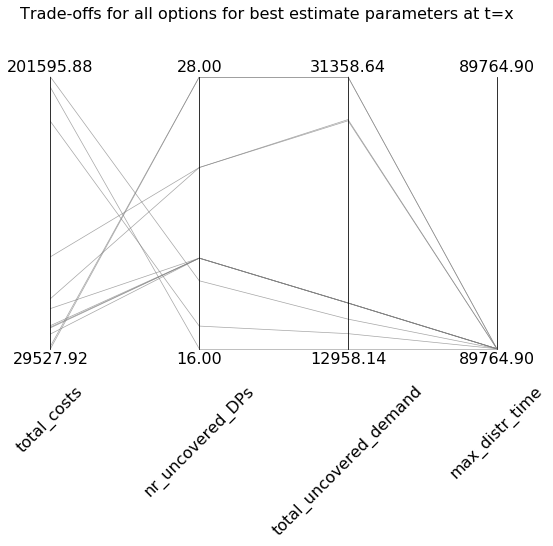

In [77]:
title = "Trade-offs for all options for best estimate parameters at t=x"
plot_optimal(df_best_est_results_opt_pols, oois, title)

In [78]:
# options for pareto sorting# minimising is default
kwargs = {"maximize_all": True}
kwargs2 = {"maximize": [0, 1]}

nondominated_BE_policy_results = np.array(pareto.eps_sort(
    [list(df_best_est_results_opt_pols.itertuples(index=True))], [1, 2, 3, 4],
    [1e-9, 1e-9, 1e-9, 1e-9]))

#Filter out those where new demand is covered
# nondominated_BE_policy_results = nondominated_BE_policy_results[nondominated_BE_policy_results[:,4] != 0]

# Put outcomes in DF
df_nondominated_BE_policy_results = pd.DataFrame(
    np.asarray(nondominated_BE_policy_results),
    columns=["pol_i"] + oois).set_index("pol_i")
df_nondominated_BE_policy_results

,total_costs,nr_uncovered_DPs,total_uncovered_demand,max_distr_time
pol_i,,,,
10.0,194942.068779,16.0,12958.144678,89764.897826
12.0,173400.890593,17.0,13978.730305,89764.897826
13.0,38846.231540,20.0,16053.552346,89764.897826
18.0,29527.915233,28.0,31358.638301,89764.897826


In [79]:
df_nondominated_BE_policy_results

,total_costs,nr_uncovered_DPs,total_uncovered_demand,max_distr_time
pol_i,,,,
10.0,194942.068779,16.0,12958.144678,89764.897826
12.0,173400.890593,17.0,13978.730305,89764.897826
13.0,38846.231540,20.0,16053.552346,89764.897826
18.0,29527.915233,28.0,31358.638301,89764.897826


In [80]:
nondominated_BE_policy_results

array([[1.00000000e+01, 1.94942069e+05, 1.60000000e+01, 1.29581447e+04,
        8.97648978e+04],
       [1.20000000e+01, 1.73400891e+05, 1.70000000e+01, 1.39787303e+04,
        8.97648978e+04],
       [1.30000000e+01, 3.88462315e+04, 2.00000000e+01, 1.60535523e+04,
        8.97648978e+04],
       [1.80000000e+01, 2.95279152e+04, 2.80000000e+01, 3.13586383e+04,
        8.97648978e+04]])

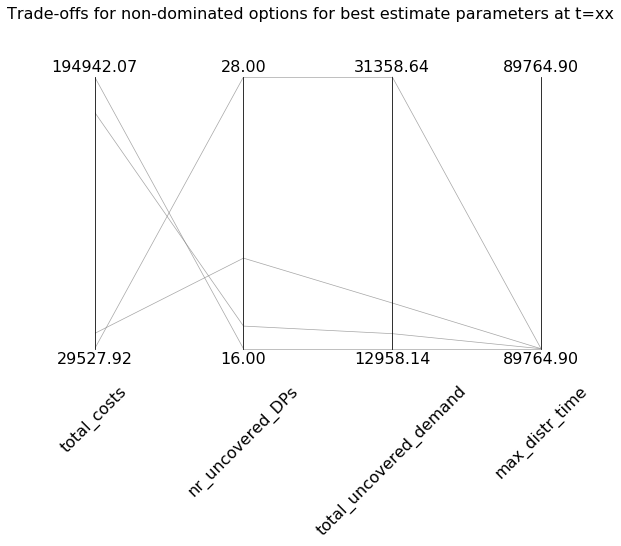

In [81]:
title = "Trade-offs for non-dominated options for best estimate parameters at t=xx"
plot_optimal(df_nondominated_BE_policy_results, oois, title)

In [82]:
# policies for all nondominated policies
nondom_i = [int(a[0]) for a in nondominated_BE_policy_results]

nondominated_BE_policies = np.array(optional_policies)[nondom_i]
nondominated_BE_policies

array([{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0},
       {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0},
       {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0},
       {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.

In [83]:
nondom_i

[10, 12, 13, 18]

In [87]:
np.array(optional_fls)[nondom_i]

array([11, 13, 14, 19])

In [88]:
nondom_i

[10, 12, 13, 18]

#### visualise all nondom pols

In [97]:
# inspect nondominated results

all_nondom_BE_pols = {name:1 if pos_i in nondom_i else 0 for pos_i, name in enumerate(FLs['Name'])}

a = FL_model(
    unit_opening_costs = 1,
    unit_transport_cost= 1, #cost per hour/ dollar or euroXX
    FL_operations_cost = 10,
    demand_per_affected = 1, # units per 1000 affected people
    graphical_representation = True,
    FL_range=4, # in hours. km? --> meters
    dist_method="from_table", #"great_circle",
    table_dir = "{}/Prepared Input Data/routing_table.csv".format(case),
    lorry_speed="nope", #km/h? -->m/s
    **SPX,
    **SPY,
    **DPX,
    **DPY,
    **FLX,
    **FLY,
    **all_nondom_BE_pols,
    **DSRDP,
    **DSRFL,
    **DPpop)
print("These are all the FLs that are in the set of non-dominated policies")
a[5]

These are all the FLs that are in the set of non-dominated policies


# EMA Framework

## EMA instantiations

In [98]:
models = []
t = 0
model = Model("flmodelt{}".format(t), FL_model)

model.locations = [
    Constant("DPX{}".format(i), x)
    for i, x in zip(DPs.index, DPs['longitude'])
] + [
    Constant("DPY{}".format(i), y)
    for i, y in zip(DPs.index, DPs['latitude'])
] + [
    Constant("SPX{}".format(i), x)
    for i, x in zip(SPs.index, SPs['longitude_deg'])
] + [
    Constant("SPY{}".format(i), y)
    for i, y in zip(SPs.index, SPs['latitude_deg'])
] + [Constant("FLX{}".format(i), x) for i, x in zip(FLs.index, FLs['Lon'])] + [
    Constant("FLY{}".format(i), y) for i, y in zip(FLs.index, FLs['Lat'])
]

# model.locations_uncertain =   [
#     RealParameter("FLX{}".format(i), DPs['Longitude (DD)'].min(), DPs['Longitude (DD)'].max()) for i in range(nr_of_FLs)
# ] + [RealParameter("FLY{}".format(i), DPs['Latitude (DD)'].min(), DPs['Latitude (DD)'].max()) for i in range(nr_of_FLs)]

model.constants = [
    Constant('graphical_representation', False),
    Constant('dist_method', 'from_table'),
    Constant('table_dir', "{}/Prepared Input Data/routing_table.csv".format(case))
    #list of other constants
] + model.locations + [  # population DPs
    Constant("DPpop{}".format(i), pop)
    for i, pop in zip(DPs.index, DPs['population'])
]

# Reachability of Demand Points and Facility Locations can be disrupted
# Disruption also determines demand (disr-1)*pop
model.disruptions = [
    #For Validation
    RealParameter("DSRFL{}".format(i), 1.49, 1.51) for i in range(FLs.shape[0])
] + [RealParameter("DSRDP{}".format(i), 1.49, 1.51) for i in range(DPs.shape[0])]


model.uncertainties = [
    RealParameter('unit_opening_costs', 50, 200),
    RealParameter('unit_transport_cost', 0.5,2),  # #cost per hour/ dollar or euroXX
    RealParameter('FL_operations_cost', 20, 50),
    RealParameter('FL_range', 2, 6),  # km TODO: great circle distance
    RealParameter(
        'demand_per_affected', 10, 50),  #units per 1000 affected people
    #list of other uncertainties
] + model.disruptions  #+ model.locations_uncertain

model.outcomes = [
    ScalarOutcome("total_costs", kind=ScalarOutcome.MINIMIZE),
    ScalarOutcome("nr_uncovered_DPs", kind=ScalarOutcome.MINIMIZE),
    ScalarOutcome("total_uncovered_demand", kind=ScalarOutcome.MINIMIZE),
    ScalarOutcome(
        "max_distr_time",
        kind=ScalarOutcome.MINIMIZE,
    )
]

models.append(model)

In [91]:
if [o.name for o in models[0].outcomes] != oois:
    print("Watch out! Oois and model outcome names are not similar!")

In [92]:
for model in models:
    print(model.name)

flmodelt0


In [93]:
nondominated_BE_policies_EMA = []
for name, pol in zip(nondom_i,nondominated_BE_policies):
    nondominated_BE_policies_EMA.append(Policy("{}".format(name), **pol))

In [94]:
nondominated_BE_policies_EMA

[{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0},
 {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0},
 {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0},
 {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 1.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13'

In [99]:
time1 = time.time()
all_scen_results_nondom_pols = perform_experiments(model,20,nondominated_BE_policies_EMA)
time2 = time.time()
print("Total time:{}".format(time2-time1),"\n","time per run = {}".format((time2-time1)/1000))

[MainProcess/INFO] performing 20 scenarios * 4 policies * 1 model(s) = 80 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 8 cases completed
[MainProcess/INFO] 16 cases completed
[MainProcess/INFO] 24 cases completed
[MainProcess/INFO] 32 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 48 cases completed
[MainProcess/INFO] 56 cases completed
[MainProcess/INFO] 64 cases completed
[MainProcess/INFO] 72 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] experiments finished


Total time:1.1753292083740234 
 time per run = 0.0011753292083740235


timelog: (3000 experiments)
1. possibly with cpu problems due to failed multiprocessing <br>
Total time:186.64591431617737 <br>
time per run = 0.18664591431617736
2. model v2 <br>
Total time:156.22968077659607  <br>
 time per run = 0.15622968077659607
3. model v2 4 policies <br>
Total time:200.71212720870972 
 time per run = 0.2007121272087097
4. 
Total time:144.36057209968567 <br>
 time per run = 0.14436057209968567
 
5. 
Total time:69.68182039260864 <br>
 time per run = 0.06968182039260865
 
6. 5000 experiments <br>
time per run = 0.03758887338638306

In [100]:
# Add parameter in filename for period t=1,2...x
ema.save_results(all_scen_results_nondom_pols, "Nepal/debug2/mordmtest1.tar.gz")

[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\debug2\mordmtest1.tar.gz


# Robustness Framework

In [102]:
all_scen_results_nondom_pols = ema.load_results("Nepal/debug2/mordmtest1.tar.gz")
experiments, outcomes = all_scen_results_nondom_pols

[MainProcess/INFO] results loaded succesfully from C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\debug2\mordmtest1.tar.gz


In [103]:
experiments['policy']

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18], dtype=object)

In [104]:
def calculate_signalNoise(data, obj):
    '''
    data : 1d array, the values of an outcome indicator for a policy
    obj  : the objective corresponding to an outcome indicator, 1 or -1
    '''
    if obj == -1: #MINIMIZE
        score = (np.mean(data)+1)*(np.std(data)+1) #to avoid division by zero if the std. deviation is zero, we can add 1.
    elif obj == 1: #MAXIMIZE
        score = (np.mean(data)+1)/(np.std(data)+1)
    return score

sigN_results = []

for policy in nondominated_BE_policies_EMA:
    #filter the outcome values corresponding to each policy using a logical index
    logical_index = experiments['policy']==int(policy.name)
    pol_outcomes = {key:outcomes[key][logical_index] for key in outcomes.keys()}
    temp_result = {}
    for ooi in models[0].outcomes:
        temp_result[ooi.name] = calculate_signalNoise(pol_outcomes[ooi.name], ooi.kind)
    sigN_results.append(temp_result)    


In [105]:
df_sigN = pd.DataFrame(sigN_results, index=[pol.name for pol in nondominated_BE_policies_EMA])
df_sigN

,max_distr_time,nr_uncovered_DPs,total_costs,total_uncovered_demand
10,1.807469e+09,119.659812,1.041195e+11,3.088157e+08
12,1.808739e+09,142.461119,9.238140e+10,2.926447e+08
13,2.037874e+09,105.980474,1.639569e+10,2.007808e+08
18,5.677185e+08,95.296913,8.972215e+09,1.051739e+09


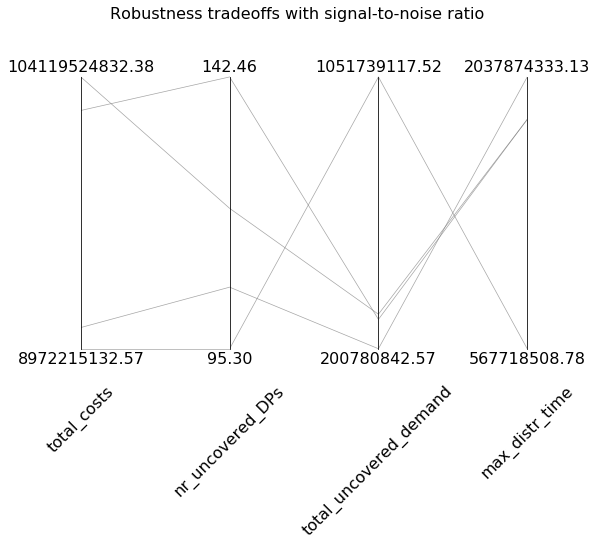

In [106]:

title = "Robustness tradeoffs with signal-to-noise ratio"
plot_optimal(df_sigN, oois, title)

In [107]:
def calculate_maxregret(data, obj):
    '''
    data : a list of 1d arrays whose shape is no_policies x no_scenarios
    obj : -1 or 1, the objective 
    '''
    data = np.array(data)
    if obj == 1: #MAXIMIZE 
        #find the best case in each scenario, therefore use the max function of numpy on the axis of policies
        zero_regrets = np.max(data, axis=0)
    elif obj == -1: #MINIMIZE
        zero_regrets = np.min(data, axis=0)
    
    #determine the regret values for eaxh policy in each scenario
    regrets = [abs(np.subtract(data[p], zero_regrets)) for p in range(data.shape[0])]
    
    max_regrets = np.max(regrets, axis=1)
    
    return max_regrets

In [108]:
reg_results = {}
# we need to iterate over the outcomes differently now, 
#because the maximum egret calculation requires the outcome values for all policies
for ooi in models[0].outcomes:
    data = []
    for policy in nondominated_BE_policies_EMA:
        logical_index = experiments['policy'] == int(policy.name) 
        data.append(outcomes[ooi.name][logical_index])
    reg_results[ooi.name] = calculate_maxregret(data, ooi.kind)
    


In [109]:
reg_results

{'total_costs': array([777966.6284788 , 587826.16347695,  97358.45434237,      0.        ]),
 'nr_uncovered_DPs': array([ 3.,  4.,  8., 18.]),
 'total_uncovered_demand': array([27185.12422243, 26402.6704817 , 11578.22989242, 63121.17982008]),
 'max_distr_time': array([23761.07500143, 18907.45536868,  6247.43457042, 84693.82489187])}

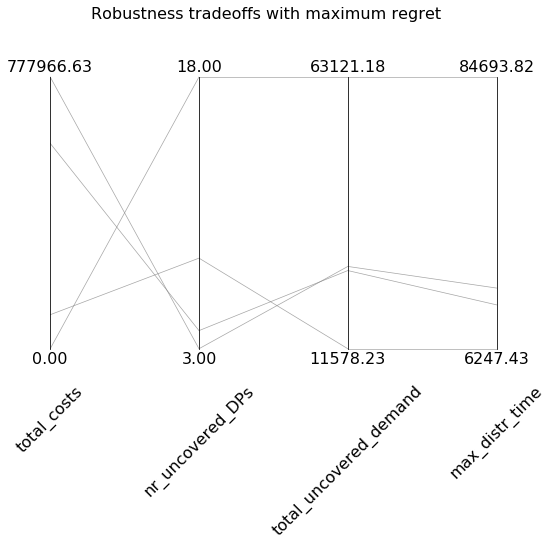

In [110]:
# we can again convert the robustness values into a dataframe. 
#However, since the results are in a dictionary, we need to do it differently.
df_regret = pd.DataFrame.from_dict(reg_results, orient='columns',)
df_regret.index = [pol.name for pol in nondominated_BE_policies_EMA]
title = "Robustness tradeoffs with maximum regret"
plot_optimal(df_regret, oois, title)

## Choose nondominated robust policies

In [111]:
df_regret

,total_costs,nr_uncovered_DPs,total_uncovered_demand,max_distr_time
10,777966.628479,3.0,27185.124222,23761.075001
12,587826.163477,4.0,26402.670482,18907.455369
13,97358.454342,8.0,11578.229892,6247.434570
18,0.000000,18.0,63121.179820,84693.824892


In [112]:
df_sigN

,max_distr_time,nr_uncovered_DPs,total_costs,total_uncovered_demand
10,1.807469e+09,119.659812,1.041195e+11,3.088157e+08
12,1.808739e+09,142.461119,9.238140e+10,2.926447e+08
13,2.037874e+09,105.980474,1.639569e+10,2.007808e+08
18,5.677185e+08,95.296913,8.972215e+09,1.051739e+09


In [113]:
all_robustness_scores = pd.merge(df_regret,df_sigN, left_index=True, right_index=True, suffixes=('_regret', '_sigN'))

In [114]:
all_robustness_scores

,total_costs_regret,nr_uncovered_DPs_regret,total_uncovered_demand_regret,max_distr_time_regret,max_distr_time_sigN,nr_uncovered_DPs_sigN,total_costs_sigN,total_uncovered_demand_sigN
10,777966.628479,3.0,27185.124222,23761.075001,1.807469e+09,119.659812,1.041195e+11,3.088157e+08
12,587826.163477,4.0,26402.670482,18907.455369,1.808739e+09,142.461119,9.238140e+10,2.926447e+08
13,97358.454342,8.0,11578.229892,6247.434570,2.037874e+09,105.980474,1.639569e+10,2.007808e+08
18,0.000000,18.0,63121.179820,84693.824892,5.677185e+08,95.296913,8.972215e+09,1.051739e+09


Use small epsilon value, because efficiency is not relevant (because of low numbers of alternatives, smaller epsilon is possible. larger epsilon leads to faster processing time)

In [115]:
# Non-dominated sorting for outcomes


# options for pareto sorting# minimising is default
kwargs = {"maximize_all":True}
kwargs2 = {"maximize":[0,1]}

robust_nondominated_policies = pareto.eps_sort([list(all_robustness_scores.itertuples(index=True))],[i+1 for i in range(all_robustness_scores.shape[1])], [1e-9] * all_robustness_scores.shape[1])
robust_nondominated_policies

[['10',
  777966.6284787955,
  3.0,
  27185.124222427326,
  23761.075001428097,
  1807468723.2828314,
  119.65981230472525,
  104119524832.38225,
  308815691.3344361],
 ['12',
  587826.1634769498,
  4.0,
  26402.670481697936,
  18907.45536868273,
  1808739064.5800214,
  142.46111859076254,
  92381400521.18077,
  292644683.53339636],
 ['13',
  97358.45434236989,
  8.0,
  11578.229892420157,
  6247.434570422774,
  2037874333.1324642,
  105.98047439060116,
  16395693562.196705,
  200780842.57477403],
 ['18',
  0.0,
  18.0,
  63121.17982007605,
  84693.82489187186,
  567718508.7766978,
  95.29691345147374,
  8972215132.568073,
  1051739117.5200969]]

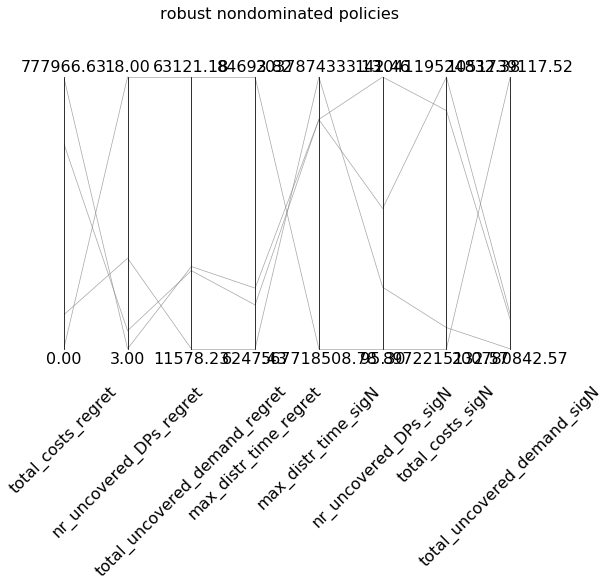

In [116]:
if len(robust_nondominated_policies) ==0:
    print("something went wrong")
elif len(robust_nondominated_policies) == 1:
    print(robust_nondominated_policies)
else:
    temp_cols = ["pol_i"]+list(all_robustness_scores.columns)

    df_temp = pd.DataFrame(robust_nondominated_policies, columns=temp_cols).set_index("pol_i")

    plot_optimal(df_temp, all_robustness_scores.columns, "robust nondominated policies")

In [117]:
np.asarray(robust_nondominated_policies)[:,0]

array(['10', '12', '13', '18'], dtype='<U18')

In [118]:
np.asarray(robust_nondominated_policies)[:,0]

array(['10', '12', '13', '18'], dtype='<U18')

# Next iteration Framework